In [31]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("default")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import scipy
import math

from plotly.subplots import make_subplots

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from itertools import product

%matplotlib inline

### <font color='157699'> **Importar Datos** </font>
---

In [2]:
# Lectura de archivo csv
df_original = pd.read_csv("https://raw.githubusercontent.com/Leostark95/Analitica_II_Proyecto_1/main/data/ecommerce-data.csv", sep=",")

# Obtener los 10 primeros registros
df_original.head(10)

,Reviews,Reviews_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Purchase
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
5,0,0.0,0,0.0,19,154.216667,0.015789,0.024561,0.0,0.0,Feb,2,2,1,3,Returning_Visitor,False,False
6,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.4,Feb,2,4,3,3,Returning_Visitor,False,False
7,1,0.0,0,0.0,0,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,2,1,5,Returning_Visitor,True,False
8,0,0.0,0,0.0,2,37.000000,0.000000,0.100000,0.0,0.8,Feb,2,2,2,3,Returning_Visitor,False,False
9,0,0.0,0,0.0,3,738.000000,0.000000,0.022222,0.0,0.4,Feb,2,4,1,2,Returning_Visitor,False,False


### <font color='157699'> **Transformación de Variables** </font>
---

In [43]:
df_original[['Weekend', 'Purchase']] = df_original[['Weekend', 'Purchase']].astype(int)
df_original[['OperatingSystems','Browser',
             'Region', 'TrafficType', 'VisitorType']] = df_original[['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType']].astype(str)

In [33]:
# Variables numéricas

df_nums = df_original.select_dtypes(include=['int64', 'int32', 'float64'])

In [34]:
# Variables numéricas escaladas

scaler = MinMaxScaler()
df_nums_scaled = pd.DataFrame(scaler.fit_transform(df_nums), columns=df_nums.columns)

In [35]:
# Variables categóricas

df_cats = df_original.select_dtypes(include=['object'])

In [36]:
# Variables categóricas dummizadas

df_cats_dummies = pd.get_dummies(df_cats)

### <font color='157699'> **Dataframes** </font>
---

In [37]:
# df concatenado variables numéricas y dummizadas

df = pd.concat([df_nums, df_cats_dummies], axis=1)

In [38]:
# df_1 concatenado variables escaladas y dummizadas

df_1 = pd.concat([df_nums_scaled, df_cats_dummies], axis=1)

---

In [44]:
X = df_1.drop('Purchase', axis=1)
y = df_1['Purchase']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Tamaño del conjunto de entrenamiento: ', X_train.shape)
print('Tamaño del conjunto de validación: ', X_test.shape)

Tamaño del conjunto de entrenamiento:  (9864, 74)
Tamaño del conjunto de validación:  (2466, 74)


---

## <font color='056938'> **Modelo Base** </font>
---

In [47]:
# Entrenamiento del modelo
modelo = LogisticRegression(max_iter=10000)

# Ajustar el modelo a los datos
modelo.fit(X_train, y_train)

# Desempeño en el entrenamiento
y_train_pred = modelo.predict(X_train)
print('Exactitud en el entrenamiento: %.3f'  %accuracy_score(y_train, y_train_pred))

Exactitud en el entrenamiento: 0.881


In [48]:
y_pred = modelo.predict(X_test)
# Exactitud en el conjunto de validación
print('Exactitud en la validacion: %.3f'  %accuracy_score(y_test, y_pred))

Exactitud en la validacion: 0.864


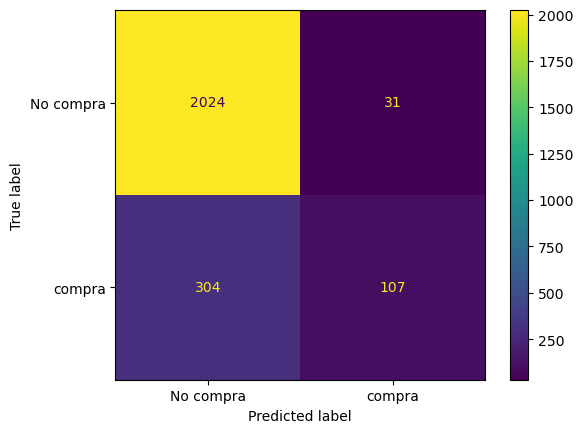

In [49]:
mc= confusion_matrix(y_test, y_pred)
mc_display = ConfusionMatrixDisplay(confusion_matrix=mc, display_labels=['No compra', 'compra'])
mc_display.plot()
plt.show()

## <font color='056938'> **Modelo Base con BC** </font>
---

In [ ]:
X_train_1 = X_train.copy()
X_test_1 = X_test.copy()

# Entrenamiento del modelo
modelo_1 = LogisticRegression(class_weight="balanced", random_state=142)

# Ajustar el modelo a los datos
modelo_1.fit(X_train_1, y_train)

# Desempeño en el entrenamiento
y_train_pred_1 = modelo_1.predict(X_train_1)

print('Exactitud en el entrenamiento: %.3f'  %accuracy_score(y_train, y_train_pred1) )

In [51]:
tn, fp, fn, tp = mc.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
especificidad = tn / (fp + tn)
f1_score = 2*(precision*recall)/(precision+recall)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Especificidad: {especificidad}')
print(f'F1 score: {f1_score}')

Precision: 0.7753623188405797
Recall: 0.26034063260340634
Especificidad: 0.9849148418491485
F1 score: 0.3897996357012751


## <font color='056938'> **Métodos de ensamble** </font>
---

## <font color='056938'> **Random Forest** </font>
---

In [23]:
# Entrenamiento del modelo
# ==============================================================================
ranfor = RandomForestClassifier(
            class_weight = 'balanced'
            criterion    = 'gini',
            n_jobs       = -1,
            random_state = 123
         )
ranfor.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=123)

In [24]:
# Métricas de desempeño
# ==============================================================================
print ("Train - Accuracy :", metrics.accuracy_score(y_train, ranfor.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, ranfor.predict(X_train)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, ranfor.predict(X_test)))
print ("Test - classification report :", metrics.classification_report(y_test, ranfor.predict(X_test)))

Train - Accuracy : 1.0
Train - classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8367
           1       1.00      1.00      1.00      1497

    accuracy                           1.00      9864
   macro avg       1.00      1.00      1.00      9864
weighted avg       1.00      1.00      1.00      9864

Test - Accuracy : 0.8884833738848338
Test - classification report :               precision    recall  f1-score   support

           0       0.91      0.97      0.94      2055
           1       0.75      0.50      0.60       411

    accuracy                           0.89      2466
   macro avg       0.83      0.73      0.77      2466
weighted avg       0.88      0.89      0.88      2466



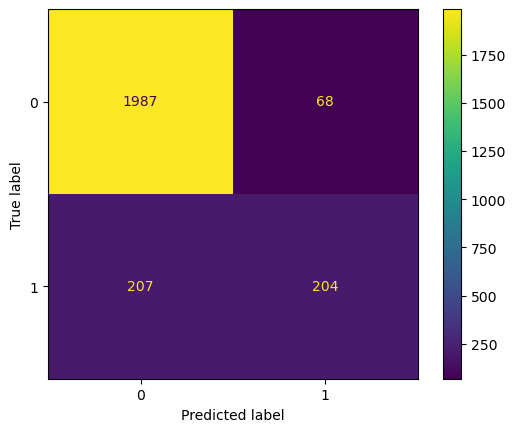

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Matriz de confusion
cm = confusion_matrix(y_test, ranfor.predict(X_test))
# Visualización de la matriz de confusion
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

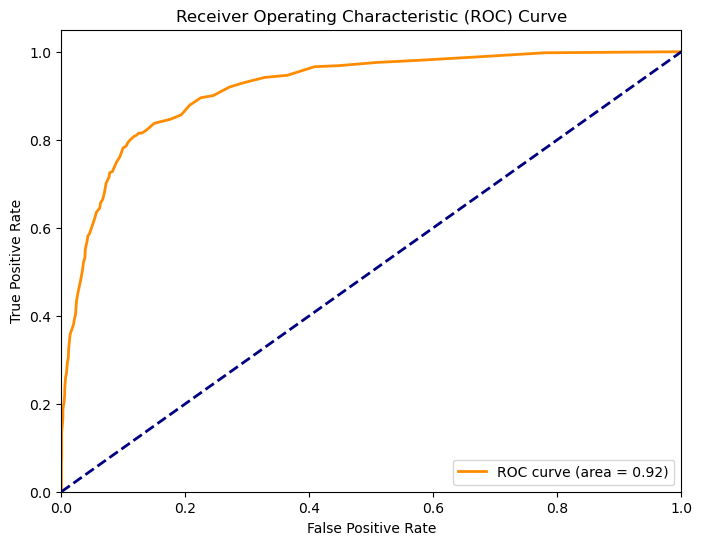

Valor del AUC: 0.9167794412772834


In [13]:
from sklearn.metrics import roc_curve, auc

# Predicciones de probabilidad en el conjunto de prueba
y_pred_proba = ranfor.predict_proba(X_test)[:,1]

# Calcula la tasa de falsos positivos (fpr), la tasa de verdaderos positivos (tpr)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Calcula el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Valor del AUC
print("Valor del AUC:", roc_auc)


## <font color='056938'> **XGBoost Classifier** </font>
---

In [14]:
#%pip install xgboost
from xgboost import XGBClassifier
# Entrenamiento del modelo: N_ESTIMATORS = 100, LEARNING_RATE = 0.1, , MAX_DEPTH = 4
# ===================================================================================
xgb = XGBClassifier(
    #n_estimators = 100,
    #learning_rate= 0.1,
    #max_depth = 4,
    random_state = 123
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [15]:
# Métricas de desempeño
# ==============================================================================
print ("Train - Accuracy :", metrics.accuracy_score(y_train, xgb.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, xgb.predict(X_train)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, xgb.predict(X_test)))
print ("Test - classification report :", metrics.classification_report(y_test, xgb.predict(X_test)))

Train - Accuracy : 0.9877331711273317
Train - classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      8367
           1       0.99      0.93      0.96      1497

    accuracy                           0.99      9864
   macro avg       0.99      0.96      0.98      9864
weighted avg       0.99      0.99      0.99      9864

Test - Accuracy : 0.8896999188969992
Test - classification report :               precision    recall  f1-score   support

           0       0.92      0.95      0.93      2055
           1       0.71      0.58      0.64       411

    accuracy                           0.89      2466
   macro avg       0.81      0.77      0.79      2466
weighted avg       0.88      0.89      0.89      2466



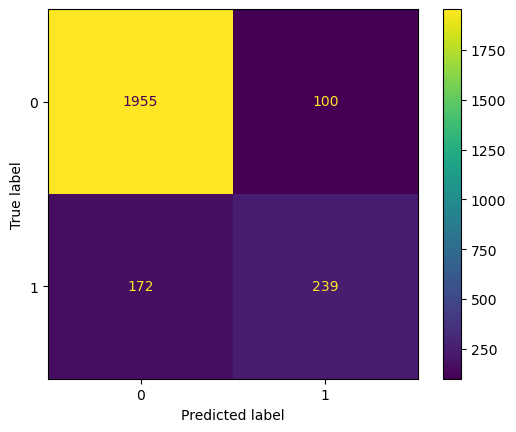

In [16]:
# Matriz de confusión
# ==============================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Matriz de confusion
cm = confusion_matrix(y_test, xgb.predict(X_test))
# Visualización de la matriz de confusion
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

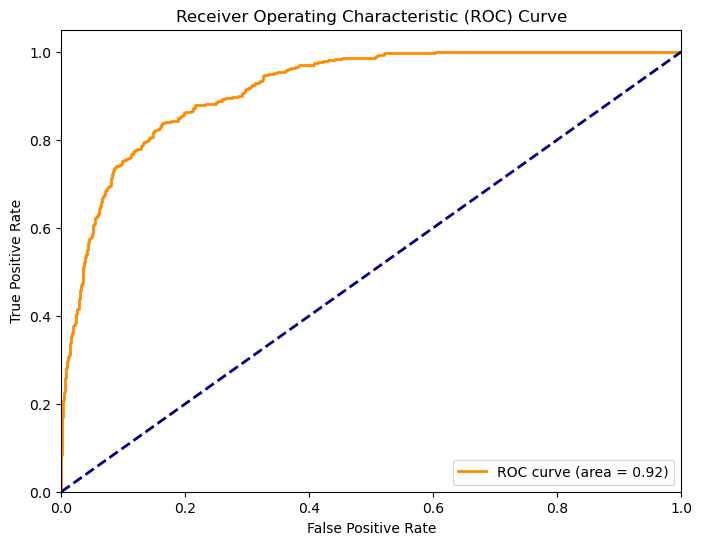

Valor del AUC: 0.9170783975941417


In [17]:
from sklearn.metrics import roc_curve, auc

# Predicciones de probabilidad en el conjunto de prueba
y_pred_proba = xgb.predict_proba(X_test)[:,1]

# Calcula la tasa de falsos positivos (fpr), la tasa de verdaderos positivos (tpr)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Calcula el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Valor del AUC
print("Valor del AUC:", roc_auc)


## <font color='056938'> **Support Vector Machine** </font>
---

In [18]:
from sklearn.svm import SVC

# Entrenamiento del modelo SVM: KERNEL = 'linear', C = 1.5, class_weight = 'balanced'
# =================================================================================
svm_model = SVC(
                #C = 1.5, 
                #kernel = 'linear',
                #class_weight = 'balanced',
                #max_iter =-1, 
                random_state=123)
svm_model.fit(X_train, y_train)

SVC(random_state=123)

In [19]:
# Métricas de desempeño
# ==============================================================================
print ("Train - Accuracy :", metrics.accuracy_score(y_train, svm_model.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, svm_model.predict(X_train)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, svm_model.predict(X_test)))
print ("Test - classification report :", metrics.classification_report(y_test, svm_model.predict(X_test)))

Train - Accuracy : 0.8508718572587186
Train - classification report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92      8367
           1       0.93      0.02      0.04      1497

    accuracy                           0.85      9864
   macro avg       0.89      0.51      0.48      9864
weighted avg       0.86      0.85      0.79      9864

Test - Accuracy : 0.8349553933495539
Test - classification report :               precision    recall  f1-score   support

           0       0.83      1.00      0.91      2055
           1       0.83      0.01      0.02       411

    accuracy                           0.83      2466
   macro avg       0.83      0.51      0.47      2466
weighted avg       0.83      0.83      0.76      2466



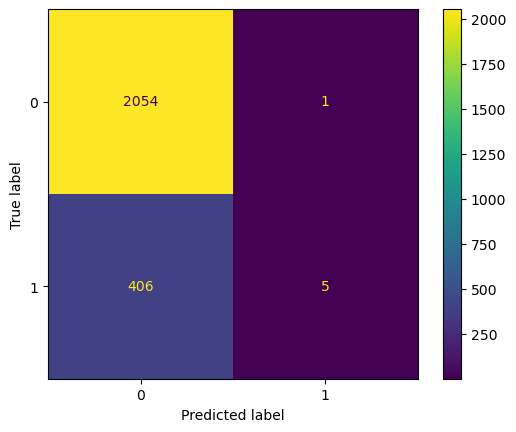

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Matriz de confusion
cm = confusion_matrix(y_test, svm_model.predict(X_test))
# Visualización de la matriz de confusion
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

## <font color='056938'> **Tuning de hiperparámetros** </font>
---

In [21]:
# Importar librerias adicionales
# ==============================================================================
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import pprint

In [22]:
# Modelos Base
# ==============================================================================
print("+----------------------\nModelo Base - Random Forest:")
pprint.pprint(ranfor.get_params())
print("+----------------------\nModelo Base - XGBoost:")
pprint.pprint(xgb.get_params())
print("+----------------------\nModelo Base - SVM:")
pprint.pprint(svm_model.get_params())

+----------------------
Modelo Base - Random Forest:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}
+----------------------
Modelo Base - XGBoost:
{'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'ma

## <font color='056938'> **Random Forest (Tinning)** </font>
---

In [1]:
## Definir cuadricula de búsqueda
# =================================================
parameters = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True],
}


In [61]:
# Búsqueda en Cuadricula
# ==============================================================================

# Modelo para tunning
ranfor = RandomForestClassifier(
    n_jobs = -1,
    random_state= 123
)

# Definición de cuadricula de búsqueda
grid_search = GridSearchCV(ranfor, parameters, cv=5, scoring='roc_auc', n_jobs=-1)

# Iniciar la Búsqueda
grid_result = grid_search.fit(X_train, y_train)

In [ ]:
## Definir cuadricula de búsqueda
# =================================================
parameters = {
    'max_depth': [None,5,10,15],
    'max_features': [0.6, 0.8, 1],
    'max_leaf_nodes': [8,10,12,14],
    'min_samples_leaf': [6,8,10,12],
    'n_estimators': [100,150,300]
}